In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [9]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

In [17]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

### Do updates

In [6]:
update_indexes()

Updated 2020-05-24, max actual date:     2020-05-22


In [8]:
update_stocks()

Updated 2020-05-24, max actual date:     2020-05-22


In [10]:
update_stocks_nc()

Updated 2020-05-24, max actual date:     2020-05-22


In [11]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 2463 and indexes: 23


## Single plot

### Plot code

In [15]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [12]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [13]:
papier = 'INTROL'

In [14]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/showletter/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


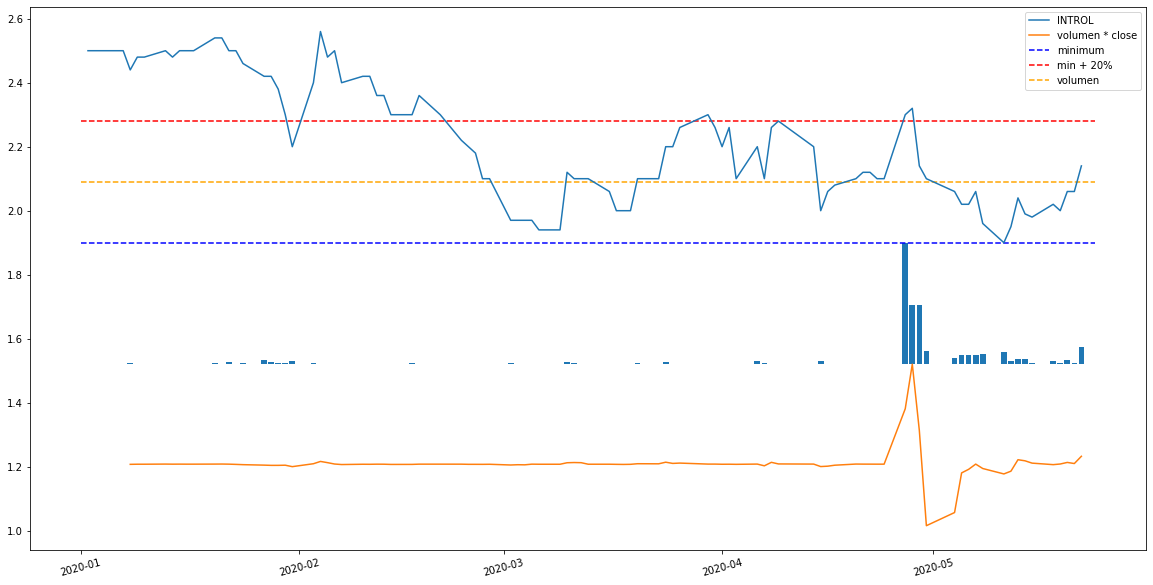

In [16]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [18]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: INTROL, currently at 2.14, with potential 19.63% to top
Max before crisis: 2.56
Crisis bottom: 1.94
Max after crisis drop: 2.32, at 2020-04-28 00:00:00
Stats after Max: [2.32 2.14 2.1  2.06 2.02 2.02 2.06 1.96 1.9  1.95 2.04 1.99 1.98 2.02
 2.   2.06 2.06 2.14]


## Skaner

In [19]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [20]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 2463/2463 [00:15<00:00, 158.04it/s]


In [22]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [23]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 25000)
                              ,:].sort_values('drop_current', ascending=True)

In [24]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [25]:
skaner_df_see.dropna().shape

(176, 15)

In [26]:
skaner_df_see.dropna().head(10)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.280,2.835883e+04,1.270,2.200,2.600,0.218,1.090,2.200,-42.27,-15.38,400.00,28.44,685.71,-87.27
0,ELKOP,0.304,2.682140e+04,1.080,0.836,0.744,0.290,1.240,1.250,29.19,12.37,327.59,4.83,311.18,-75.68
0,MABION,25.900,3.535715e+04,51.100,80.000,73.500,17.960,31.000,103.600,-36.12,8.84,72.61,44.21,300.00,-75.00
0,BRASTER,0.334,4.393318e+05,0.370,1.040,1.730,0.200,0.405,1.162,-64.42,-39.88,102.50,67.00,247.90,-71.26
0,ELBUDOWA,2.850,1.165059e+05,7.680,6.260,10.100,1.200,5.300,9.240,22.68,-38.02,341.67,137.50,224.21,-69.16
0,CCC,43.700,5.350955e+05,96.500,132.500,153.900,24.980,51.820,133.000,-27.17,-13.91,107.45,74.94,204.35,-67.14
0,MOBIMEDIA,0.400,1.672299e+05,0.725,0.446,0.129,0.246,0.400,1.210,62.56,245.74,62.60,62.60,202.50,-66.94
0,ALIOR,13.435,7.947397e+05,27.680,38.020,51.750,11.750,16.920,38.240,-27.20,-26.53,44.00,14.34,184.63,-64.87
0,WORKSERV,0.440,3.933142e+05,0.502,0.860,2.210,0.342,0.480,1.144,-41.63,-61.09,40.35,28.65,160.00,-61.54
0,MILLENNIUM,2.506,1.467597e+06,6.065,5.650,9.535,2.298,3.880,6.395,7.35,-40.74,68.84,9.05,155.19,-60.81


## Model

In [108]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

#     df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
#     df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
#     df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    df.loc[:, 'max_1d'] = df.loc[:, 'HIGH'].rolling(1).max()
    df.loc[df.loc[:, 'max_1d'].shift(-1) > df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 1
    df.loc[df.loc[:, 'max_1d'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1)*1.03,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
#     for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
#         for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
#             df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
#             df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
#             df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
#             df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [109]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [110]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [111]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 99%|█████████▉| 185/187 [02:17<00:01,  1.35it/s]


In [113]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 184/184 [00:05<00:00, 36.49it/s]


In [114]:
df_papers = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_papers = pd.concat([df_papers , df])
    pbar.update(1)
pbar.close()

100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


In [115]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

837

In [116]:
df_indexes = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes = pd.concat([df_indexes, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 44.49it/s]


In [117]:
df_indexes = df_indexes.reset_index().groupby('DTYYYYMMDD')[['OPEN', 'HIGH', 'CLOSE']].agg(['mean', 'max', 'std']).dropna(how = 'all',axis = 1)
df_indexes.columns = 'foreign_stocks_' + df_indexes.columns.get_level_values(1) + '_chng_' + df_indexes.columns.get_level_values(0)
df_indexes = df_indexes.dropna(how = 'all',axis = 1)

In [118]:
df_merged = df_papers.merge(df_indexes, left_index=True, right_index=True, how = 'left')

train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

In [119]:
valid = df_merged.loc[df_merged.index >= '2020-04-01'].copy()

df_merged = df_merged.loc[df_merged.index < '2020-04-01']

cut_date = '2019-11-01'
train_data = df_merged.loc[df_merged.index < cut_date,train_cols]
eval_data = df_merged.loc[df_merged.index >= cut_date,train_cols]
train_labels = df_merged.loc[df_merged.index < cut_date,'target'].values
eval_labels = df_merged.loc[df_merged.index >= cut_date,'target'].values

In [120]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                               #bagging_temperature=3,
                               #random_strength = 3,
                               use_best_model=True,
                               min_data_in_leaf=200,
                               #sampling_frequency=1,
                               #subsample = 0.8,
                           depth=5,
                               has_time=True,
                          #thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [121]:
model = get_model()

In [122]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.7476698	test: 0.7560030	best: 0.7560030 (0)	total: 19ms	remaining: 3m 9s
1:	learn: 0.7557907	test: 0.7635933	best: 0.7635933 (1)	total: 45.4ms	remaining: 3m 47s
2:	learn: 0.7591212	test: 0.7672139	best: 0.7672139 (2)	total: 69.1ms	remaining: 3m 50s
3:	learn: 0.7599215	test: 0.7678911	best: 0.7678911 (3)	total: 88.1ms	remaining: 3m 40s
4:	learn: 0.7609209	test: 0.7694206	best: 0.7694206 (4)	total: 107ms	remaining: 3m 33s
5:	learn: 0.7617564	test: 0.7715742	best: 0.7715742 (5)	total: 133ms	remaining: 3m 41s
6:	learn: 0.7624470	test: 0.7713680	best: 0.7715742 (5)	total: 159ms	remaining: 3m 47s
7:	learn: 0.7626367	test: 0.7717575	best: 0.7717575 (7)	total: 176ms	remaining: 3m 39s
8:	learn: 0.7630318	test: 0.7730324	best: 0.7730324 (8)	total: 195ms	remaining: 3m 36s
9:	learn: 0.7631021	test: 0.7729903	best: 0.7730324 (8)	total: 218ms	remaining: 3m 38s
10:	learn: 0.7634470	test: 0.7736709	best: 0.7736709 (10)	total: 242ms	remaining: 3m 40s
11:	learn: 0.7638130	test: 0.7733875	bes

95:	learn: 0.7711551	test: 0.7783002	best: 0.7783249 (94)	total: 1.88s	remaining: 3m 14s
96:	learn: 0.7711823	test: 0.7783259	best: 0.7783259 (96)	total: 1.9s	remaining: 3m 13s
97:	learn: 0.7712065	test: 0.7783072	best: 0.7783259 (96)	total: 1.92s	remaining: 3m 13s
98:	learn: 0.7712726	test: 0.7783737	best: 0.7783737 (98)	total: 1.94s	remaining: 3m 13s
99:	learn: 0.7713418	test: 0.7784299	best: 0.7784299 (99)	total: 1.96s	remaining: 3m 14s
100:	learn: 0.7713895	test: 0.7784761	best: 0.7784761 (100)	total: 1.98s	remaining: 3m 13s
101:	learn: 0.7714472	test: 0.7784580	best: 0.7784761 (100)	total: 1.99s	remaining: 3m 13s
102:	learn: 0.7715154	test: 0.7784741	best: 0.7784761 (100)	total: 2.01s	remaining: 3m 13s
103:	learn: 0.7715483	test: 0.7785026	best: 0.7785026 (103)	total: 2.03s	remaining: 3m 12s
104:	learn: 0.7715770	test: 0.7785580	best: 0.7785580 (104)	total: 2.05s	remaining: 3m 13s
105:	learn: 0.7716087	test: 0.7784956	best: 0.7785580 (104)	total: 2.07s	remaining: 3m 12s
106:	learn

190:	learn: 0.7742860	test: 0.7796922	best: 0.7796922 (190)	total: 3.73s	remaining: 3m 11s
191:	learn: 0.7743114	test: 0.7797051	best: 0.7797051 (191)	total: 3.76s	remaining: 3m 11s
192:	learn: 0.7743300	test: 0.7797105	best: 0.7797105 (192)	total: 3.78s	remaining: 3m 11s
193:	learn: 0.7743351	test: 0.7797181	best: 0.7797181 (193)	total: 3.79s	remaining: 3m 11s
194:	learn: 0.7743628	test: 0.7797242	best: 0.7797242 (194)	total: 3.81s	remaining: 3m 11s
195:	learn: 0.7743967	test: 0.7797185	best: 0.7797242 (194)	total: 3.83s	remaining: 3m 11s
196:	learn: 0.7744193	test: 0.7797201	best: 0.7797242 (194)	total: 3.85s	remaining: 3m 11s
197:	learn: 0.7744315	test: 0.7797374	best: 0.7797374 (197)	total: 3.87s	remaining: 3m 11s
198:	learn: 0.7744666	test: 0.7797360	best: 0.7797374 (197)	total: 3.88s	remaining: 3m 11s
199:	learn: 0.7745087	test: 0.7797360	best: 0.7797374 (197)	total: 3.9s	remaining: 3m 10s
200:	learn: 0.7745301	test: 0.7797467	best: 0.7797467 (200)	total: 3.92s	remaining: 3m 10s


291:	learn: 0.7762049	test: 0.7801778	best: 0.7801867 (287)	total: 5.59s	remaining: 3m 5s
292:	learn: 0.7762238	test: 0.7801974	best: 0.7801974 (292)	total: 5.6s	remaining: 3m 5s
293:	learn: 0.7762341	test: 0.7801925	best: 0.7801974 (292)	total: 5.62s	remaining: 3m 5s
294:	learn: 0.7762465	test: 0.7801970	best: 0.7801974 (292)	total: 5.64s	remaining: 3m 5s
295:	learn: 0.7762629	test: 0.7802186	best: 0.7802186 (295)	total: 5.66s	remaining: 3m 5s
296:	learn: 0.7762715	test: 0.7802334	best: 0.7802334 (296)	total: 5.68s	remaining: 3m 5s
297:	learn: 0.7762784	test: 0.7802339	best: 0.7802339 (297)	total: 5.69s	remaining: 3m 5s
298:	learn: 0.7763045	test: 0.7802487	best: 0.7802487 (298)	total: 5.71s	remaining: 3m 5s
299:	learn: 0.7763185	test: 0.7802615	best: 0.7802615 (299)	total: 5.73s	remaining: 3m 5s
300:	learn: 0.7763288	test: 0.7802484	best: 0.7802615 (299)	total: 5.75s	remaining: 3m 5s
301:	learn: 0.7763389	test: 0.7802551	best: 0.7802615 (299)	total: 5.77s	remaining: 3m 5s
302:	learn:

391:	learn: 0.7774634	test: 0.7805353	best: 0.7805364 (380)	total: 7.47s	remaining: 3m 3s
392:	learn: 0.7774783	test: 0.7805375	best: 0.7805375 (392)	total: 7.5s	remaining: 3m 3s
393:	learn: 0.7774900	test: 0.7805505	best: 0.7805505 (393)	total: 7.51s	remaining: 3m 3s
394:	learn: 0.7775047	test: 0.7805622	best: 0.7805622 (394)	total: 7.53s	remaining: 3m 3s
395:	learn: 0.7775123	test: 0.7805582	best: 0.7805622 (394)	total: 7.55s	remaining: 3m 3s
396:	learn: 0.7775255	test: 0.7805470	best: 0.7805622 (394)	total: 7.58s	remaining: 3m 3s
397:	learn: 0.7775314	test: 0.7805600	best: 0.7805622 (394)	total: 7.59s	remaining: 3m 3s
398:	learn: 0.7775390	test: 0.7805622	best: 0.7805622 (398)	total: 7.61s	remaining: 3m 3s
399:	learn: 0.7775439	test: 0.7805614	best: 0.7805622 (398)	total: 7.63s	remaining: 3m 3s
400:	learn: 0.7775489	test: 0.7805562	best: 0.7805622 (398)	total: 7.65s	remaining: 3m 3s
401:	learn: 0.7775619	test: 0.7805673	best: 0.7805673 (401)	total: 7.67s	remaining: 3m 3s
402:	learn:

489:	learn: 0.7784673	test: 0.7808093	best: 0.7808093 (489)	total: 9.34s	remaining: 3m 1s
490:	learn: 0.7784859	test: 0.7808069	best: 0.7808093 (489)	total: 9.36s	remaining: 3m 1s
491:	learn: 0.7785079	test: 0.7808179	best: 0.7808179 (491)	total: 9.38s	remaining: 3m 1s
492:	learn: 0.7785128	test: 0.7808027	best: 0.7808179 (491)	total: 9.4s	remaining: 3m 1s
493:	learn: 0.7785199	test: 0.7807984	best: 0.7808179 (491)	total: 9.42s	remaining: 3m 1s
494:	learn: 0.7785302	test: 0.7808049	best: 0.7808179 (491)	total: 9.44s	remaining: 3m 1s
495:	learn: 0.7785384	test: 0.7808097	best: 0.7808179 (491)	total: 9.45s	remaining: 3m 1s
496:	learn: 0.7785459	test: 0.7808081	best: 0.7808179 (491)	total: 9.47s	remaining: 3m 1s
497:	learn: 0.7785603	test: 0.7808164	best: 0.7808179 (491)	total: 9.49s	remaining: 3m 1s
498:	learn: 0.7785690	test: 0.7808433	best: 0.7808433 (498)	total: 9.51s	remaining: 3m
499:	learn: 0.7785800	test: 0.7808617	best: 0.7808617 (499)	total: 9.53s	remaining: 3m 1s
500:	learn: 0.

590:	learn: 0.7794481	test: 0.7812010	best: 0.7812010 (590)	total: 11.2s	remaining: 2m 58s
591:	learn: 0.7794624	test: 0.7812105	best: 0.7812105 (591)	total: 11.2s	remaining: 2m 58s
592:	learn: 0.7794699	test: 0.7812141	best: 0.7812141 (592)	total: 11.2s	remaining: 2m 58s
593:	learn: 0.7794774	test: 0.7812139	best: 0.7812141 (592)	total: 11.3s	remaining: 2m 58s
594:	learn: 0.7794898	test: 0.7812092	best: 0.7812141 (592)	total: 11.3s	remaining: 2m 58s
595:	learn: 0.7794971	test: 0.7812126	best: 0.7812141 (592)	total: 11.3s	remaining: 2m 58s
596:	learn: 0.7795070	test: 0.7812145	best: 0.7812145 (596)	total: 11.3s	remaining: 2m 58s
597:	learn: 0.7795213	test: 0.7812023	best: 0.7812145 (596)	total: 11.3s	remaining: 2m 58s
598:	learn: 0.7795282	test: 0.7812061	best: 0.7812145 (596)	total: 11.4s	remaining: 2m 58s
599:	learn: 0.7795327	test: 0.7812251	best: 0.7812251 (599)	total: 11.4s	remaining: 2m 58s
600:	learn: 0.7795394	test: 0.7812188	best: 0.7812251 (599)	total: 11.4s	remaining: 2m 58s

687:	learn: 0.7802887	test: 0.7813777	best: 0.7814015 (683)	total: 13.1s	remaining: 2m 57s
688:	learn: 0.7803023	test: 0.7813706	best: 0.7814015 (683)	total: 13.1s	remaining: 2m 57s
689:	learn: 0.7803145	test: 0.7813731	best: 0.7814015 (683)	total: 13.1s	remaining: 2m 57s
690:	learn: 0.7803195	test: 0.7813697	best: 0.7814015 (683)	total: 13.2s	remaining: 2m 57s
691:	learn: 0.7803270	test: 0.7813612	best: 0.7814015 (683)	total: 13.2s	remaining: 2m 57s
692:	learn: 0.7803397	test: 0.7813652	best: 0.7814015 (683)	total: 13.2s	remaining: 2m 57s
693:	learn: 0.7803536	test: 0.7813712	best: 0.7814015 (683)	total: 13.2s	remaining: 2m 57s
694:	learn: 0.7803649	test: 0.7813699	best: 0.7814015 (683)	total: 13.2s	remaining: 2m 57s
695:	learn: 0.7803719	test: 0.7813576	best: 0.7814015 (683)	total: 13.3s	remaining: 2m 57s
696:	learn: 0.7803804	test: 0.7813550	best: 0.7814015 (683)	total: 13.3s	remaining: 2m 57s
697:	learn: 0.7803899	test: 0.7813473	best: 0.7814015 (683)	total: 13.3s	remaining: 2m 57s

787:	learn: 0.7810419	test: 0.7814822	best: 0.7814822 (787)	total: 15s	remaining: 2m 55s
788:	learn: 0.7810529	test: 0.7814898	best: 0.7814898 (788)	total: 15s	remaining: 2m 54s
789:	learn: 0.7810622	test: 0.7814881	best: 0.7814898 (788)	total: 15s	remaining: 2m 54s
790:	learn: 0.7810653	test: 0.7814869	best: 0.7814898 (788)	total: 15s	remaining: 2m 54s
791:	learn: 0.7810721	test: 0.7814576	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
792:	learn: 0.7810765	test: 0.7814581	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
793:	learn: 0.7810861	test: 0.7814583	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
794:	learn: 0.7810940	test: 0.7814563	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
795:	learn: 0.7811034	test: 0.7814525	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
796:	learn: 0.7811088	test: 0.7814479	best: 0.7814898 (788)	total: 15.1s	remaining: 2m 54s
797:	learn: 0.7811134	test: 0.7814627	best: 0.7814898 (788)	total: 15.2s	remaining: 2m 54s
798:	le

888:	learn: 0.7817909	test: 0.7815788	best: 0.7815875 (882)	total: 16.9s	remaining: 2m 52s
889:	learn: 0.7818124	test: 0.7815787	best: 0.7815875 (882)	total: 16.9s	remaining: 2m 52s
890:	learn: 0.7818161	test: 0.7815709	best: 0.7815875 (882)	total: 16.9s	remaining: 2m 52s
891:	learn: 0.7818204	test: 0.7815751	best: 0.7815875 (882)	total: 16.9s	remaining: 2m 52s
892:	learn: 0.7818242	test: 0.7815812	best: 0.7815875 (882)	total: 16.9s	remaining: 2m 52s
893:	learn: 0.7818303	test: 0.7815810	best: 0.7815875 (882)	total: 17s	remaining: 2m 52s
894:	learn: 0.7818369	test: 0.7815898	best: 0.7815898 (894)	total: 17s	remaining: 2m 52s
895:	learn: 0.7818426	test: 0.7815945	best: 0.7815945 (895)	total: 17s	remaining: 2m 52s
896:	learn: 0.7818506	test: 0.7815939	best: 0.7815945 (895)	total: 17s	remaining: 2m 52s
897:	learn: 0.7818587	test: 0.7815993	best: 0.7815993 (897)	total: 17.1s	remaining: 2m 52s
898:	learn: 0.7818667	test: 0.7815974	best: 0.7815993 (897)	total: 17.1s	remaining: 2m 52s
899:	le

980:	learn: 0.7824463	test: 0.7817637	best: 0.7817637 (980)	total: 18.8s	remaining: 2m 52s
981:	learn: 0.7824517	test: 0.7817643	best: 0.7817643 (981)	total: 18.8s	remaining: 2m 52s
982:	learn: 0.7824589	test: 0.7817656	best: 0.7817656 (982)	total: 18.8s	remaining: 2m 52s
983:	learn: 0.7824668	test: 0.7817712	best: 0.7817712 (983)	total: 18.8s	remaining: 2m 52s
984:	learn: 0.7824748	test: 0.7817661	best: 0.7817712 (983)	total: 18.9s	remaining: 2m 52s
985:	learn: 0.7824790	test: 0.7817662	best: 0.7817712 (983)	total: 18.9s	remaining: 2m 52s
986:	learn: 0.7824836	test: 0.7817622	best: 0.7817712 (983)	total: 18.9s	remaining: 2m 52s
987:	learn: 0.7824900	test: 0.7817718	best: 0.7817718 (987)	total: 18.9s	remaining: 2m 52s
988:	learn: 0.7824997	test: 0.7817672	best: 0.7817718 (987)	total: 18.9s	remaining: 2m 52s
989:	learn: 0.7825061	test: 0.7817642	best: 0.7817718 (987)	total: 19s	remaining: 2m 52s
990:	learn: 0.7825108	test: 0.7817619	best: 0.7817718 (987)	total: 19s	remaining: 2m 52s
991

1070:	learn: 0.7830462	test: 0.7817039	best: 0.7817718 (987)	total: 20.4s	remaining: 2m 50s
1071:	learn: 0.7830550	test: 0.7817047	best: 0.7817718 (987)	total: 20.5s	remaining: 2m 50s
1072:	learn: 0.7830593	test: 0.7817128	best: 0.7817718 (987)	total: 20.5s	remaining: 2m 50s
1073:	learn: 0.7830641	test: 0.7817044	best: 0.7817718 (987)	total: 20.5s	remaining: 2m 50s
1074:	learn: 0.7830707	test: 0.7817234	best: 0.7817718 (987)	total: 20.5s	remaining: 2m 50s
1075:	learn: 0.7830763	test: 0.7817209	best: 0.7817718 (987)	total: 20.5s	remaining: 2m 50s
1076:	learn: 0.7830840	test: 0.7817239	best: 0.7817718 (987)	total: 20.6s	remaining: 2m 50s
1077:	learn: 0.7830864	test: 0.7817332	best: 0.7817718 (987)	total: 20.6s	remaining: 2m 50s
1078:	learn: 0.7830914	test: 0.7817349	best: 0.7817718 (987)	total: 20.6s	remaining: 2m 50s
1079:	learn: 0.7830983	test: 0.7817351	best: 0.7817718 (987)	total: 20.6s	remaining: 2m 50s
1080:	learn: 0.7831020	test: 0.7817364	best: 0.7817718 (987)	total: 20.6s	remain

In [123]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll40std_diff_LOW_CLOSE,4.091444
1,diff_LOW_HIGH,3.289582
2,roll20max_diff_LOW_HIGH,3.148126
3,roll120std_diff_LOW_HIGH,3.103320
4,roll40std_diff_OPEN_CLOSE,2.873445
5,roll20m_diff_LOW_HIGH,2.618693
6,roll10m_diff_LOW_HIGH,2.492329
7,roll240std_diff_OPEN_CLOSE,2.241647
8,roll80m_diff_LOW_CLOSE,1.990921
9,roll80std_diff_LOW_HIGH,1.984018


In [124]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

191

### Check performance

In [125]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [126]:
preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [127]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[11129,   791],
       [ 2997,  1284]])

In [128]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(11129, 791, 2997, 1284)

In [129]:
(tn + tp) / (tn + tp + fp + fn)

0.7661872723905931

In [130]:
tp / (tp + fp)

0.6187951807228915

In [131]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.795179,0.204821
1.0,0.604995,0.395005


In [132]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

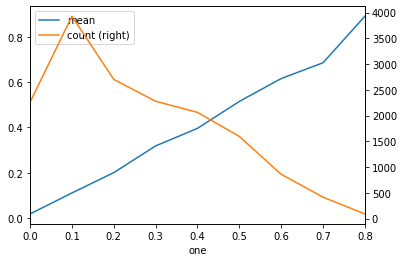

In [133]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [134]:
df_res_grouped

,mean,count
one,,
0.0,0.018134,2261
0.1,0.110715,3929
0.2,0.200518,2703
0.3,0.318561,2279
0.4,0.396025,2063
0.5,0.515038,1596
0.6,0.616009,862
0.7,0.685851,417
0.8,0.891304,92


#### Check valid

In [135]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [136]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.5] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [137]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[3414,  352],
       [1365,  501]])

In [138]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(3414, 352, 1365, 501)

In [139]:
(tn + tp) / (tn + tp + fp + fn)

0.6951349431818182

In [140]:
tp / (tp + fp)

0.5873388042203986

### Prediction

In [141]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [142]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [143]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 98%|█████████▊| 172/176 [02:17<00:03,  1.25it/s]


In [146]:
qtransformed.qsize()

176

In [147]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 176/176 [00:00<00:00, 1036.64it/s]


In [148]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [149]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [150]:
prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")

'2020-05-22'

In [155]:
res.loc[res.DTYYYYMMDD == prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")]\
.sort_values('pred_prob', ascending=False).dropna(how='all', axis = 1).head(10)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,pred_prob
1619,2020-05-22,TELGAM,0.298,0.298,0.360,0.352,0.686693
6490,2020-05-22,RAFAKO,0.730,0.719,0.877,0.855,0.683084
1078,2020-05-22,SOFTBLUE,1.450,1.420,1.580,1.460,0.663108
1881,2020-05-22,MBFGROUP,4.140,4.080,4.380,4.180,0.617416
1539,2020-05-22,GLCOSMED,2.700,2.640,3.160,2.900,0.614025
407,2020-05-22,HORNIGOLD,0.204,0.172,0.208,0.188,0.579305
1167,2020-05-22,IGORIA,0.254,0.210,0.276,0.250,0.574712
1831,2020-05-22,INNOGENE,12.050,11.200,12.850,12.200,0.549026
2215,2020-05-22,LIBET,1.820,1.755,1.895,1.880,0.548278
681,2020-05-22,BIZTECH,0.202,0.188,0.204,0.188,0.541904


In [156]:
last_day = res.loc[res.DTYYYYMMDD == '2020-05-21'].sort_values('pred_prob', ascending=False)

In [159]:
last_day.mean().dropna()

OPEN                 1090.083899
LOW                  1084.775691
HIGH                 1097.518673
CLOSE                1089.241821
fut_OPEN             1082.820146
fut_LOW              1076.454573
fut_HIGH             1088.250246
fut_CLOSE            1084.936483
fOPEN_fHIGH_chng        1.910583
fOPEN_fCLOSE_chng      -0.231876
CLOSE_fOPEN_chng       -0.146368
HIGH_fHIGH_chng        -0.538580
LOW_fLOW_chng           0.046790
pred_prob               0.273428
dtype: float64

In [161]:
last_day.loc[last_day.pred_prob > 0.5].mean().dropna()

OPEN                 4.526533
LOW                  4.328000
HIGH                 4.836933
CLOSE                4.568600
fut_OPEN             4.576667
fut_LOW              4.450867
fut_HIGH             4.935000
fut_CLOSE            4.826867
fOPEN_fHIGH_chng     5.570886
fOPEN_fCLOSE_chng    0.356484
CLOSE_fOPEN_chng    -0.501264
HIGH_fHIGH_chng     -1.709280
LOW_fLOW_chng        5.649002
pred_prob            0.600965
dtype: float64

In [164]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.groupby('DTYYYYMMDD').mean().mean()

OPEN                   424.066784
LOW                    419.346979
HIGH                   428.186384
CLOSE                  423.879061
fut_OPEN               422.093370
fut_LOW                417.471469
fut_HIGH               426.154969
fut_CLOSE              421.991845
fOPEN_fHIGH_chng         3.642125
fOPEN_fCLOSE_chng        0.119318
CLOSE_fOPEN_chng        -0.061902
HIGH_fHIGH_chng          0.019194
LOW_fLOW_chng            0.008389
fOPEN_f5CLOSE_chng      -2.227800
fOPEN_f5MAX_chng         4.642223
fOPEN_f10CLOSE_chng     -5.833797
fOPEN_f10MAX_chng        6.942891
pred_prob                0.351608
dtype: float64

In [165]:
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    6.445267
LOW                     6.166331
HIGH                    7.122613
CLOSE                   6.770252
fut_OPEN                7.088107
fut_LOW                 6.640893
fut_HIGH                7.464428
fut_CLOSE               6.945134
fOPEN_fHIGH_chng        7.731042
fOPEN_fCLOSE_chng       1.054484
CLOSE_fOPEN_chng        0.616072
HIGH_fHIGH_chng         0.075563
LOW_fLOW_chng           2.913224
fOPEN_f5CLOSE_chng     -0.688493
fOPEN_f5MAX_chng        9.298084
fOPEN_f10CLOSE_chng    -1.922955
fOPEN_f10MAX_chng      16.384425
pred_prob               0.612157
dtype: float64

In [166]:
res_see.loc[res_see.CLOSE_fOPEN_chng > 0].groupby('DTYYYYMMDD').mean().mean()

OPEN                   792.129111
LOW                    782.241463
HIGH                   799.478676
CLOSE                  790.249666
fut_OPEN               796.176193
fut_LOW                788.312963
fut_HIGH               804.748161
fut_CLOSE              797.719468
fOPEN_fHIGH_chng         3.258552
fOPEN_fCLOSE_chng       -0.247558
CLOSE_fOPEN_chng         2.427211
HIGH_fHIGH_chng          1.497168
LOW_fLOW_chng            2.148139
fOPEN_f5CLOSE_chng      -0.652351
fOPEN_f5MAX_chng         4.848232
fOPEN_f10CLOSE_chng      0.206376
fOPEN_f10MAX_chng        8.760676
pred_prob                0.333256
dtype: float64

In [168]:
res_see.loc[(res_see.CLOSE_fOPEN_chng < 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    4.029728
LOW                     3.721655
HIGH                    4.366920
CLOSE                   4.035295
fut_OPEN                3.918293
fut_LOW                 3.655773
fut_HIGH                4.193362
fut_CLOSE               3.901594
fOPEN_fHIGH_chng        9.176411
fOPEN_fCLOSE_chng       2.657322
CLOSE_fOPEN_chng       -3.852873
HIGH_fHIGH_chng        -1.982943
LOW_fLOW_chng           0.091532
fOPEN_f5CLOSE_chng      4.277316
fOPEN_f5MAX_chng       12.688645
fOPEN_f10CLOSE_chng     7.283210
fOPEN_f10MAX_chng      19.699026
pred_prob               0.610441
dtype: float64

In [169]:
res_see.loc[(res_see.CLOSE_fOPEN_chng > 0) & 
           (res_see.pred_prob > 0.5)].groupby('DTYYYYMMDD').mean().mean()

OPEN                    9.539822
LOW                     9.211430
HIGH                   10.606195
CLOSE                  10.144744
fut_OPEN               10.432050
fut_LOW                 9.785710
fut_HIGH               10.965294
fut_CLOSE              10.212218
fOPEN_fHIGH_chng        6.234884
fOPEN_fCLOSE_chng      -1.037913
CLOSE_fOPEN_chng        4.180150
HIGH_fHIGH_chng         1.988518
LOW_fLOW_chng           4.518872
fOPEN_f5CLOSE_chng     -2.153009
fOPEN_f5MAX_chng        6.855048
fOPEN_f10CLOSE_chng     2.519441
fOPEN_f10MAX_chng      17.204631
pred_prob               0.613240
dtype: float64

## Reports

### Extract raw reports

In [174]:
reports_names = os.listdir('reports/')

In [178]:
one_rep  = pd.read_html('reports/' + reports_names[0])

In [182]:
one_rep[1].shape

(19, 39)

In [194]:
%%time
cols_extended = list()
col_counter = dict()
df_reports = pd.DataFrame()
for r in (reports_names):
    try:
        one_rep  = pd.read_html('reports/' + r)
    except Exception:
        print(r + ' Didnt go through!')
        continue
    for i in range(len(one_rep)):
        if (one_rep[i].shape[1] > 8):
            one_rep = one_rep[i]
            one_rep.columns = ['col_name'] + list(one_rep.columns[1:])
            one_rep = one_rep.set_index('col_name').transpose().reset_index()
            one_rep.loc[:, 'name'] = r
            print(one_rep.columns)
            df_reports = pd.concat([df_reports, one_rep], sort=False, axis = 0)
            if 'name' not in df_reports.columns:
                print('name not in the columns')
            #print(one_rep.columns)
            cols_extended.append(one_rep.columns)
            for c in one_rep.columns:
                if c in col_counter.keys():
                    col_counter[c] = col_counter[c] + 1
                else:
                    col_counter[c] = 0
            break

Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA', 'name'],
      dtype='object', name='col_name')
Index(['index', 'Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Ko

ValueError: Plan shapes are not aligned

In [195]:
one_rep.head(2)

col_name,index,Data publikacji,Przychody odsetkowe,Przychody odsetkowe,Koszty odsetkowe,Wynik z tytułu odsetek,Przychody prowizyjne,Koszty prowizyjne,Wynik z tytułu prowizji,Przychody z tytułu dywidend,...,Ogólne koszty administracyjne,Pozostałe koszty operacyjne,Wynik operacyjny,Udział w zyskach jednostek podporządkowanych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2015/Q1 (mar 15),2015-05-07,191 425,191 425,116 954,74 471,134 432,21 084,113 348,0,...,-129 333,-4 463,62 724,1 187,63 911,0,63 133,63 023,74 296,"raporty-IDEA-BANK,Q.html"
1,2015/Q2 (cze 15),2015-07-29,177 425k/k -7.31%~sektor -4.26%,177 425k/k -7.31%~sektor -4.26%,104 545k/k -10.61%~sektor -9.24%,72 880k/k -2.14%~sektor +3.65%,158 776k/k +18.11%~sektor +4.29%,31 145k/k +47.72%~sektor +5.86%,127 631k/k +12.60%~sektor +6.80%,0,...,-133 861k/k -3.50%~sektor -3.31%,-12 654k/k -183.53%~sektor -51.52%,66 041k/k +5.29%~sektor -1.39%,5 276k/k +344.48%~sektor +102.88%,71 317k/k +11.59%~sektor -1.57%,0,117 957k/k +86.84%~sektor +1.64%,117 917k/k +87.10%~sektor -0.83%,77 688k/k +4.57%~sektor -1.10%,"raporty-IDEA-BANK,Q.html"


In [196]:
 df_reports.head(2)

col_name,index,Data publikacji,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),...,Koszty finansowe,Pozostałe przychody (koszty),Zysk z działalności gospodarczej,Wynik zdarzeń nadzwyczajnych,Zysk przed opodatkowaniem,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,EBITDA,name
0,2011/Q1 (mar 11),NaN,282 089,236 690,16 740,11 945,16 714,1 327,252,17 789,...,11 684,249,7 290,0,7 290,0,6 681,6 681,30 239,"raporty-ROKITA,Q.html"
1,2011/Q2 (cze 11),2011-08-31,120 180k/k -57.40%~sektor -6.11%,104 329k/k -55.92%~sektor -7.29%,7 965k/k -52.42%~sektor +8.14%,4 317k/k -63.86%~sektor +6.42%,3 569k/k -78.65%~sektor -16.66%,3 543k/k +166.99%~sektor +147.69%,15k/k -94.05%~sektor -21.72%,7 097k/k -60.10%~sektor -22.39%,...,-220k/k -101.88%~sektor -10.86%,-126k/k -150.60%~sektor -70.53%,7 391k/k +1.39%~sektor +1.39%,0,7 391k/k +1.39%~sektor +1.39%,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,20 119k/k -33.47%~sektor -15.70%,"raporty-ROKITA,Q.html"


In [197]:
test_cols = [c for c in one_rep if c in df_reports.columns]

In [198]:
test_cols

['index',
 'Data publikacji',
 'Pozostałe przychody operacyjne',
 'Pozostałe koszty operacyjne',
 'Zysk przed opodatkowaniem',
 'Zysk (strata) netto z działalności zaniechanej',
 'Zysk netto',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'EBITDA',
 'name']

In [201]:
pd.concat([df_reports, one_rep[test_cols]], sort=True).head(2)

,Data publikacji,EBITDA,Koszty finansowe,Koszty ogólnego zarządu,Koszty sprzedaży,Pozostałe koszty operacyjne,Pozostałe przychody (koszty),Pozostałe przychody operacyjne,Przychody finansowe,Przychody ze sprzedaży,...,Wynik zdarzeń nadzwyczajnych,Zysk (strata) netto z działalności zaniechanej,Zysk netto,Zysk netto akcjonariuszy jednostki dominującej,Zysk operacyjny (EBIT),Zysk przed opodatkowaniem,Zysk z działalności gospodarczej,Zysk ze sprzedaży,index,name
0,NaN,30 239,11 684,11 945,16 740,252,249,1 327,936,282 089,...,0,0,6 681,6 681,17 789,7 290,7 290,16 714,2011/Q1 (mar 11),"raporty-ROKITA,Q.html"
1,2011-08-31,20 119k/k -33.47%~sektor -15.70%,-220k/k -101.88%~sektor -10.86%,4 317k/k -63.86%~sektor +6.42%,7 965k/k -52.42%~sektor +8.14%,15k/k -94.05%~sektor -21.72%,-126k/k -150.60%~sektor -70.53%,3 543k/k +166.99%~sektor +147.69%,200k/k -78.63%~sektor -60.23%,120 180k/k -57.40%~sektor -6.11%,...,0,2 033,9 276k/k +38.84%~sektor +2.49%,9 276k/k +38.84%~sektor -8.81%,7 097k/k -60.10%~sektor -22.39%,7 391k/k +1.39%~sektor +1.39%,7 391k/k +1.39%~sektor +1.39%,3 569k/k -78.65%~sektor -16.66%,2011/Q2 (cze 11),"raporty-ROKITA,Q.html"


### Analyze

In [170]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
